In [2]:
from tqdm import tqdm
import joblib
from collections import Counter

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from utils import get_DF, get_indices

from gensim.models import Word2Vec


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

In [3]:
df = get_DF()

In [17]:
w2v = Word2Vec.load("CCC_embeddings/embeddings/w2v.model")    

target_vecs = {}
for trgt in tqdm(df.target.unique()):
    if trgt in w2v.wv:
        target_vecs[trgt] = w2v.wv[trgt]

df = df[df.target.isin(target_vecs.keys())]        
 
scaler = StandardScaler(with_mean=False).fit(np.stack(target_vecs.values()))

target_vecs = {w: scaler.transform(v.reshape((1, -1))).reshape((-1,)) for w, v in target_vecs.items()}

100%|██████████| 72/72 [00:00<00:00, 42823.30it/s]
/home/valentin/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [18]:
target_annotations = {x:list(subdf.y) for x, subdf in df.groupby(["annotator_x", "target"])}
xs, y = list(zip(*target_annotations.items()))
x_anno, x_target = list(zip(*xs))

mldf = pd.DataFrame([x_anno, x_target, y]).T
mldf.columns = ["x_anno", "target", "y_ls"]

mldf["ratio"] = mldf.y_ls.apply(lambda ls: sum(ls)/len(ls))
mldf = mldf[mldf.ratio != 0.5]
mldf["maj_vote"] = mldf.ratio.apply(lambda r: int(r > 0.5))

mldf = pd.concat([mldf, pd.get_dummies(mldf["x_anno"])], axis=1)

In [19]:
words_shuffled = np.random.permutation(mldf.target.unique())

ratio = int(mldf.target.unique().shape[0]*0.8)
train_words = set(words_shuffled[:ratio])
msk = mldf.target.isin(train_words)

    # msk = np.random.rand(len(mldf)) < 0.7

train_df = mldf[msk]
test_df = mldf[~msk]


target_train, anno_train, Y_train = (np.stack(train_df.target.apply(lambda w: target_vecs[w])), 
                                         train_df.iloc[:, 5:].to_numpy(), 
                                         train_df.maj_vote.to_numpy())

target_test, anno_test, Y_test = (np.stack(test_df.target.apply(lambda w: target_vecs[w])),
                                        test_df.iloc[:, 5:].to_numpy(),
                                        test_df.maj_vote.to_numpy())

X_train, X_test = np.hstack([target_train, anno_train]), np.hstack([target_test, anno_test])
    

              precision    recall  f1-score   support

           0       0.76      0.64      0.70      1452
           1       0.43      0.57      0.49       688

    accuracy                           0.62      2140
   macro avg       0.60      0.61      0.59      2140
weighted avg       0.65      0.62      0.63      2140

0.6079245147030559
0.6210280373831776
[[936 516]
 [295 393]]


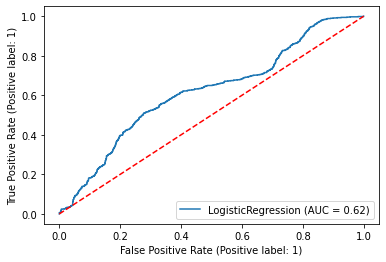

In [21]:
if True:
    
    
    logreg = LogisticRegression(penalty="none", max_iter=5000, solver="lbfgs")

    logreg.fit(X_train, Y_train)
    
    
    
    # Logistic Regression

    from sklearn.metrics import balanced_accuracy_score, classification_report, accuracy_score,\
                                    confusion_matrix, plot_roc_curve

    preds = logreg.predict(X_test)

    print(classification_report(Y_test, preds))
    b = balanced_accuracy_score(Y_test, preds)
    a = accuracy_score(Y_test, preds)
    print(b)
    print(a)

    cm = confusion_matrix(Y_test, preds)

    print(cm)

    plot_roc_curve(logreg, X_test, Y_test)
    _=plt.plot([0,1], [0,1], "--", c="r")